In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist # functions for loading and plotting MNIST
from SparseBinaryAE import SparseBinaryAE
import numpy as np
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## Loads the MNIST dataset and normalizes it using the mean (0.1307) and standard deviation (0.3081) of the training data
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
## Making AEs with 16, 64 and 256 neurons in latent layer

models = {"1024_32": SparseBinaryAE((1,28,28),2048,64)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [4]:
## Training function

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            output = model(inputs)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
        
        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [5]:
avg_lambda = lambda l: "loss: {:.4f}".format(l)
line = lambda i, l: "{}: ".format(i) + avg_lambda(l)
  
## Testing function    
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            inputs = data.clone().detach()
            output = {k: m(inputs) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction="sum").item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = "\n".join([line(k, test_loss[k]) for k in models]) + "\n"
    report = "Test set:\n" + lines        
    print(report)

In [6]:
num_epochs=50
for epoch in range(0, num_epochs):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 0 [0/50000 (0%)]	Losses 1024_32: 0.967872
Train Epoch: 0 [10000/50000 (20%)]	Losses 1024_32: 0.608507
Train Epoch: 0 [20000/50000 (40%)]	Losses 1024_32: 0.465347
Train Epoch: 0 [30000/50000 (60%)]	Losses 1024_32: 0.487081
Train Epoch: 0 [40000/50000 (80%)]	Losses 1024_32: 0.485077
Train Epoch: 0 [50000/50000 (100%)]	Losses 1024_32: 0.488822
Test set:
1024_32: loss: 0.4528

Train Epoch: 1 [0/50000 (0%)]	Losses 1024_32: 0.447497
Train Epoch: 1 [10000/50000 (20%)]	Losses 1024_32: 0.507868
Train Epoch: 1 [20000/50000 (40%)]	Losses 1024_32: 0.466086
Train Epoch: 1 [30000/50000 (60%)]	Losses 1024_32: 0.440846
Train Epoch: 1 [40000/50000 (80%)]	Losses 1024_32: 0.459098
Train Epoch: 1 [50000/50000 (100%)]	Losses 1024_32: 0.462294
Test set:
1024_32: loss: 0.4344

Train Epoch: 2 [0/50000 (0%)]	Losses 1024_32: 0.440718
Train Epoch: 2 [10000/50000 (20%)]	Losses 1024_32: 0.433318
Train Epoch: 2 [20000/50000 (40%)]	Losses 1024_32: 0.414581
Train Epoch: 2 [30000/50000 (60%)]	Losses 1024_

Save trained models..

In [7]:
#os.mkdir("./models")
for k in models:
    path = f"models/{k}"
    torch.save(models[k].state_dict(), path)

Plots of loss on validation set show smooth decrease of reconstruction and rho loss (for 256 latent dimensions and 50 epochs training). The model did not overfit on train data.

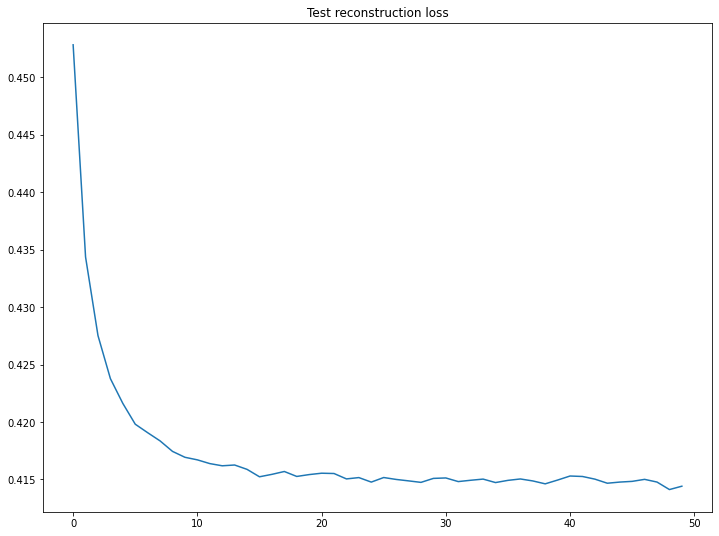

In [8]:
fig, ax = plt.subplots(1, figsize=(12,9))
ax.plot(np.array(test_log["1024_32"])[:])
ax.set_title("Test reconstruction loss")
plt.show()

Checking the model outputs from different inputs. 

1. Reconstruction of batch of images from test set;
2. Decoding identity matrix, where only one latent neuron is active;
3. Counting number of hidden neurons with activations > 0.5. The model with 256 neurons has only few of them active at same time. Setting activations of those with < 0.5 to 0 to check what decoder can generate from those few.

In [10]:
data, _ = next(iter(test_loader))

#(1.)
output = models["1024_32"](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

#(2.)
encoded = models["1024_32"].encode(data)
enc_to_plot = (encoded.view(-1, 1, 64, 32)).clamp(0, 1).data.numpy()

#(3.)
decoded = models["1024_32"].decode(torch.eye(2048))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models["1024_32"].encode(data)
    
    #(4.)
    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.    
    decoded_f = models["1024_32"].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

Number of neurons with activation > 0.5:
 tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64])


Plotting original and reconstructed images. The model makes a fairly decent reconstruction of input.

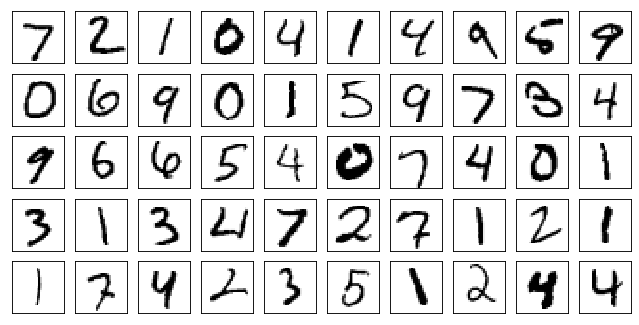

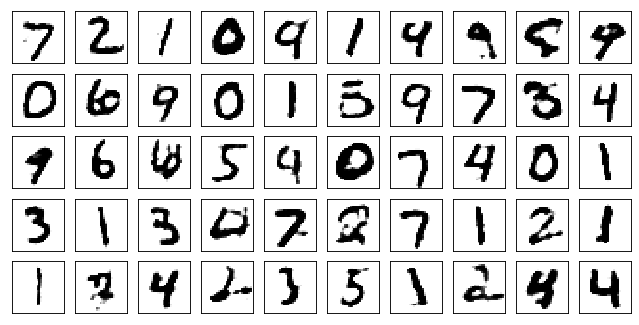

In [11]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

Plot of images reconstructed from latent space with zeroed "inactive" neurons (activation < 0.5). Many of the numbers a recognizable, so sparse latent representation did learn useful features. The deactivated neurons mostly were responsible for background noise.

In [ ]:
plot_mnist(f_to_plot, (5, 10))
plot_mnist(enc_to_plot, (5, 10))

l = len(enc_to_plot)
print("length:\n", l)
l = len(enc_to_plot)
print("shape:\n", enc_to_plot.shape)
a = np.zeros((l, l), dtype=int, order='C')
for i in range(0, l):
    for j in range(i, l):
        a[i,j]=np.count_nonzero(np.logical_xor(enc_to_plot[i,:,:,:].flatten(), enc_to_plot[j,:,:,:].flatten()), axis=0)


np.set_printoptions(threshold=np.inf, linewidth=200)
print("Hamming distances:\n", a)

Plot of decoded images from identity matrix. The images look very blurry, but even with only one neuron active in latent layer there can be seen some structure.

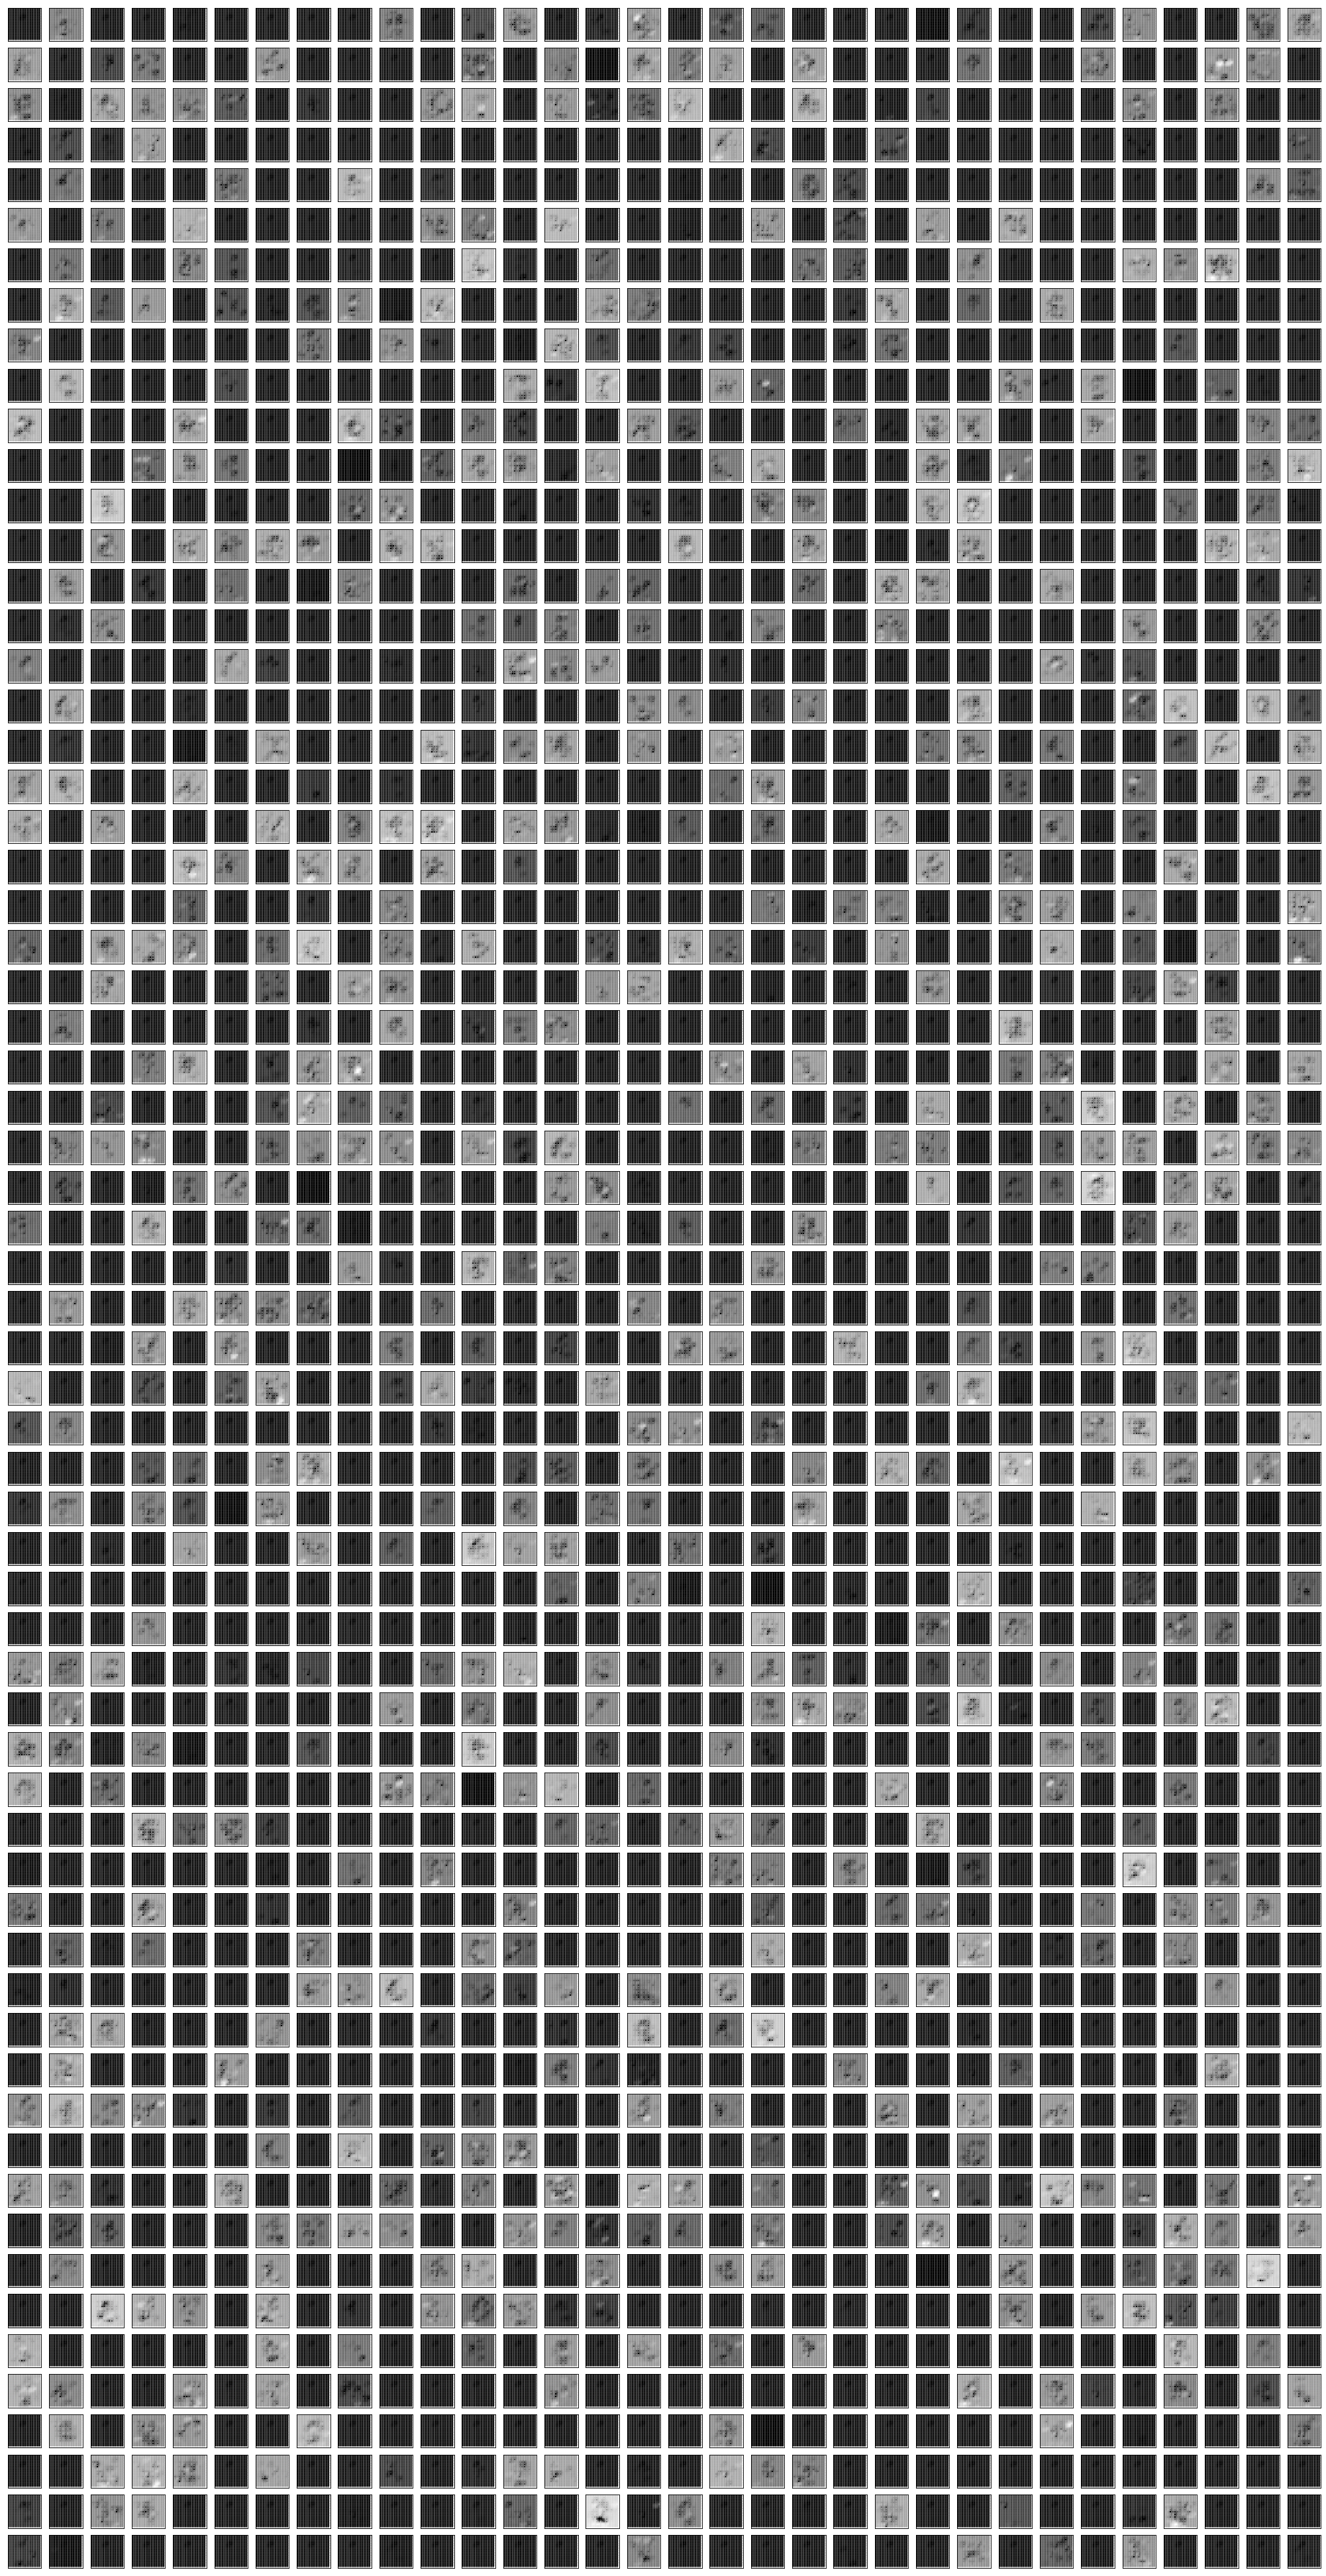

In [12]:

plot_mnist(dec_to_plot, (64, 32))

After 50 epochs of training model did quite a good job of reconstructing heavily noised images.